In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
recent_date

'2017-08-23'

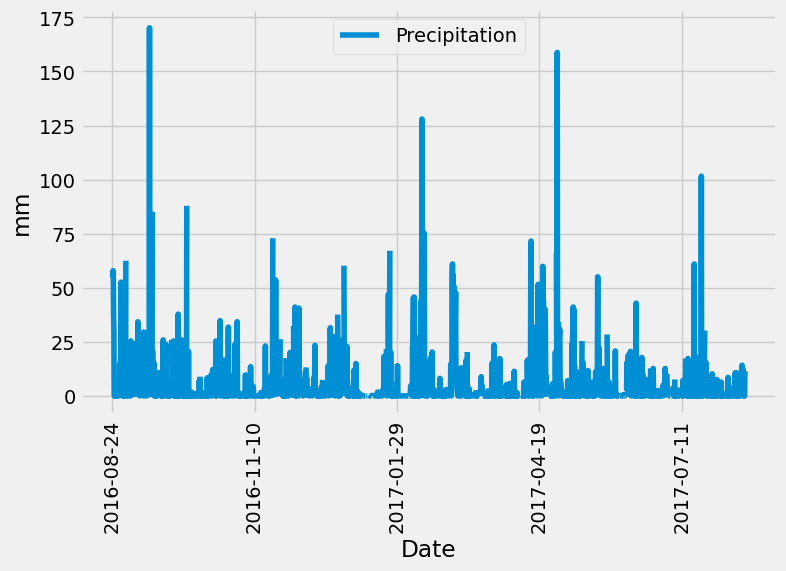

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_12m = dt.datetime.strptime(recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_scores = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_12m).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_scores_df = pd.DataFrame(precipitation_scores, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precip_scores_df.sort_values(by=['Date'], ascending = True, inplace=True)
precip_scores_df.set_index('Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_scores_df.plot(xlabel = 'Date', ylabel = 'mm', rot = 90, figsize=(8,5))
plt.legend(loc='upper center')

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_scores_df.describe()

,Precipitation
count,2015.000000
mean,4.485112
std,11.690532
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).all()

[(9,)]

In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.prcp)).\
    group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
most_active = session.query(*sel).\
    group_by(Measurement.station).\
        order_by(func.count(Measurement.prcp).desc()).\
        first()
most_active

(12.2, 29.4, 22.03582251082252)

Text(0.5, 0, 'Temperature')

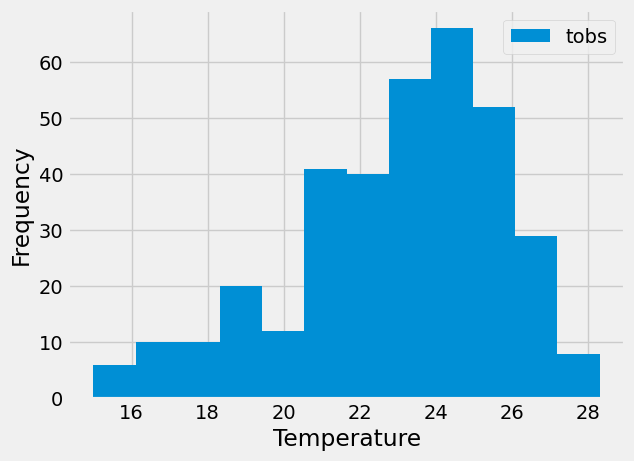

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = active_stations[0][0]
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.date, Measurement.tobs]

station_temps = session.query(*sel).\
        filter(func.strftime(Measurement.date) >= last_12m, Measurement.station == most_active_station).\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()
        
station_temps_df = pd.DataFrame(station_temps, columns=['Date', 'Temperature'])
plt.hist(station_temps_df['Temperature'], bins=12, label='tobs')
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Temperature')

# Close Session

In [22]:
# Close Session
session.close()